In [25]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
from utils import *
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm_notebook
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [3]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),      
    transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transforms_validation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
training_dataset = datasets.ImageFolder(root = "C:/Python/Pneumonia classification/chest_xray/train", transform = transforms_train)
validation_dataset = datasets.ImageFolder(root = "C:/Python/Pneumonia classification/chest_xray/test", transform = transforms_validation)

In [5]:
training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 32, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 32, shuffle = False)

In [39]:
print(len(training_loader.dataset))
print(len(validation_loader.dataset))

4720
1246


In [7]:
def im_convert(tensor):
    image = tensor.cpu().clone().squeeze().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.4914, 0.4822, 0.4465)) + np.array((0.2023, 0.1994, 0.2010))
    image = image.clip(0, 1)
    return image

In [8]:
classes = ["Normal", "Pneumonia"]

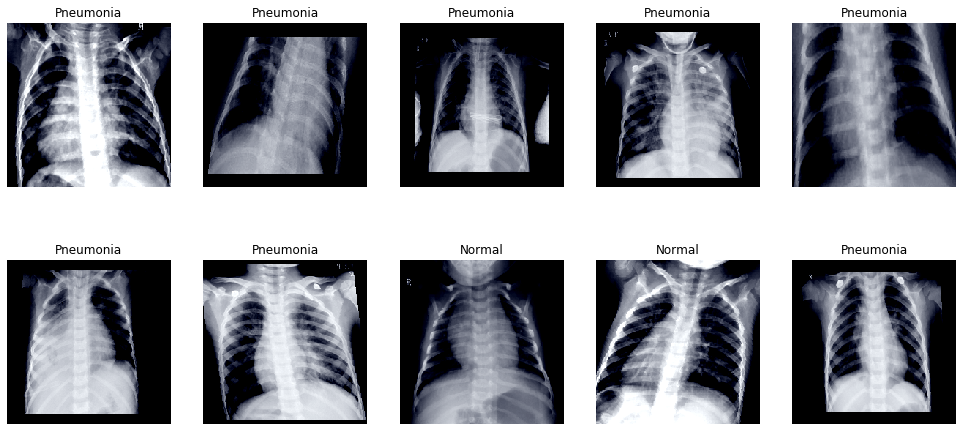

In [9]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (17, 8))
for i in np.arange(10):
    ax = fig.add_subplot(2, 5, i+1)
    plt.imshow(im_convert(images[i]), cmap = "gray")
    ax.set_title(classes[labels[i].item()])
    plt.axis("off")

In [10]:
resnet = models.resnet18(pretrained = True)
for name, param in resnet.named_parameters():
    if ("bn" not in name):
        param.requires_grad = False

In [11]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
resnet.fc = nn.Linear(in_features = 512, out_features = 2, bias = True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
tb = SummaryWriter()

grid = torchvision.utils.make_grid(images)

tb.add_image("images", grid)
tb.add_graph(resnet, images)

In [14]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
weights = torch.FloatTensor([3533/(1187+3553), 1187/(1187+3553)]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.AdamW(resnet.parameters(), lr = 1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode = "min", factor = 0.1, patience = 2, verbose = True)


In [16]:
def get_metrics(labels, preds):
    cm = confusion_matrix(labels.numpy(), preds.numpy())
    precision = precision_score(labels.numpy(), preds.numpy())
    recall = recall_score(labels.numpy(), preds.numpy())
    f1 = f1_score(labels.numpy(), preds.numpy())
    accuracy = accuracy_score(labels.numpy(), preds.numpy())

    return cm, precision, recall, f1, accuracy

def checkpoint(model, epoch):
    model_out_path = os.path.join("Pneumonia Model checkpoints", "model_epoch_{}.pth".format(epoch+1))
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))



In [17]:
def train_model(model, optimizer, scheduler, loss_function, train_loader, val_loader, num_epochs, device = "cuda"):

    logs = {"train_precision": [], "train_recall" : [], "train_f1": [],                      "train_accuracy" : [], "val_precision": [], "val_recall" : [],                     "val_f1": [], "val_accuracy" : [], "training_loss_history": [], "validation_loss_history": []}

    for i in tqdm_notebook(range(num_epochs), desc = "Progress", unit = "Epoch"):

        train_predlist = torch.zeros(0, dtype = torch.long)
        train_labellist = torch.zeros(0, dtype = torch.long)

        val_predlist = torch.zeros(0, dtype = torch.long)
        val_labellist = torch.zeros(0, dtype = torch.long)


        training_loss = 0.0
        validation_loss = 0.0
        model.train()
        for batch in tqdm_notebook(train_loader, desc = "Training Batches 1/2", leave = False):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            training_loss += loss.item()

            train_predlist = torch.cat([train_predlist, preds.view(-1).cpu()])
            train_labellist = torch.cat([train_labellist, labels.view(-1).cpu()])
            

        train_conf_mat, train_precision, train_recall, train_f1, train_accuracy = get_metrics(train_labellist, train_predlist)    

        logs["train_precision"].append(train_precision)
        logs["train_recall"].append(train_recall)
        logs["train_f1"].append(train_f1)
        logs["train_accuracy"].append(train_accuracy)

        model.eval()
        for batch in tqdm_notebook(val_loader, desc = "Validation Batches 2/2", leave = False):
            val_inputs, val_labels = batch[0].to(device), batch[1].to(device)
            val_outputs = model(val_inputs)
            val_loss = loss_function(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)
            validation_loss += val_loss.item()

            val_predlist = torch.cat([val_predlist, val_preds.view(-1).cpu()])
            val_labellist = torch.cat([val_labellist, val_labels.view(-1).cpu()])
            val_conf_mat = confusion_matrix(val_labellist.numpy(), val_predlist.numpy())

        

        val_conf_mat, val_precision, val_recall, val_f1, val_accuracy  =  get_metrics(val_labellist, val_predlist)    

        logs["val_precision"].append(val_precision)
        logs["val_recall"].append(val_recall)
        logs["val_f1"].append(val_f1)
        logs["val_accuracy"].append(val_accuracy)
        

        epoch_loss = training_loss / len(train_loader)
        val_epoch_loss = validation_loss / len(val_loader)

        logs["training_loss_history"].append(epoch_loss)
        logs["validation_loss_history"].append(val_epoch_loss)

        tb.add_scalar("Train Loss", epoch_loss, i)
        tb.add_scalar("Validation Loss", val_epoch_loss, i)
        tb.add_scalar("Train Accuracy", train_accuracy, i)
        tb.add_scalar("Validation Accuracy", val_accuracy, i)
        tb.add_scalar("Train Precision", train_precision, i)
        tb.add_scalar("Validation Precision", val_precision, i)
        tb.add_scalar("Train Recall", train_recall, i)
        tb.add_scalar("Validation Recall", val_recall, i)
        tb.add_scalar("Train Loss F1 Score", train_f1, i)
        tb.add_scalar("Validation F1 Score", val_f1, i)



        print("Epoch: ", (i+1))
        
        df = pd.DataFrame(logs)
        df.to_excel("epoch_metrics.xlsx", float_format = "%.4f")
        checkpoint(model, i)      
        scheduler.step(val_epoch_loss)

        print("Training Loss: {:.4f}, Training Precision: {:.4f}, Training Recall: {:.4f}, Training F1 Score: {:.4f}, Training Accuracy: {:.4f}".
        format(epoch_loss, train_precision, train_recall, train_f1, train_accuracy))

        print("Validation Loss: {:.4f}, Validation Precision: {:.4f}, Validation Recall: {:.4f}, Validation F1 Score: {:.4f},  Validation Accuracy: {:.4f}".
        format(val_epoch_loss, val_precision, val_recall, val_f1, val_accuracy))

    return  logs, train_conf_mat, val_conf_mat


In [18]:
model_logs, train_conf, val_conf = train_model(model = resnet, optimizer = optimizer, scheduler = scheduler, loss_function = criterion, train_loader = training_loader, val_loader = validation_loader, num_epochs = 15, device = device)

Epoch:  1
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_1.pth
Training Loss: 0.5230, Training Precision: 0.9059, Training Recall: 0.7518, Training F1 Score: 0.8217, Training Accuracy: 0.7557
Validation Loss: 0.3971, Validation Precision: 0.9544, Validation Recall: 0.7635, Validation F1 Score: 0.8483,  Validation Accuracy: 0.8379


Epoch:  2
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_2.pth
Training Loss: 0.3094, Training Precision: 0.9702, Training Recall: 0.8933, Training F1 Score: 0.9302, Training Accuracy: 0.8996
Validation Loss: 0.3331, Validation Precision: 0.9674, Validation Recall: 0.8027, Validation F1 Score: 0.8774,  Validation Accuracy: 0.8668


Epoch:  3
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_3.pth
Training Loss: 0.2271, Training Precision: 0.9756, Training Recall: 0.9157, Training F1 Score: 0.9447, Training Accuracy: 0.9197
Validation Loss: 0.2711, Validation Precision: 0.9539, Validation Recall: 0.8676, Validation F1 Score: 0.9087,  Validation Accuracy: 0.8965


Epoch:  4
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_4.pth
Training Loss: 0.1855, Training Precision: 0.9800, Training Recall: 0.9273, Training F1 Score: 0.9529, Training Accuracy: 0.9314
Validation Loss: 0.2496, Validation Precision: 0.9478, Validation Recall: 0.8838, Validation F1 Score: 0.9147,  Validation Accuracy: 0.9021


Epoch:  5
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_5.pth
Training Loss: 0.1640, Training Precision: 0.9849, Training Recall: 0.9261, Training F1 Score: 0.9546, Training Accuracy: 0.9341
Validation Loss: 0.2244, Validation Precision: 0.9455, Validation Recall: 0.9149, Validation F1 Score: 0.9299,  Validation Accuracy: 0.9181


Epoch:  6
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_6.pth
Training Loss: 0.1527, Training Precision: 0.9808, Training Recall: 0.9414, Training F1 Score: 0.9607, Training Accuracy: 0.9424
Validation Loss: 0.2312, Validation Precision: 0.9504, Validation Recall: 0.9054, Validation F1 Score: 0.9273,  Validation Accuracy: 0.9157


Epoch:  7
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_7.pth
Training Loss: 0.1428, Training Precision: 0.9820, Training Recall: 0.9437, Training F1 Score: 0.9625, Training Accuracy: 0.9449
Validation Loss: 0.2245, Validation Precision: 0.9535, Validation Recall: 0.9135, Validation F1 Score: 0.9331,  Validation Accuracy: 0.9222


Epoch:  8
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_8.pth
Training Loss: 0.1302, Training Precision: 0.9844, Training Recall: 0.9496, Training F1 Score: 0.9667, Training Accuracy: 0.9511
Validation Loss: 0.2224, Validation Precision: 0.9576, Validation Recall: 0.9149, Validation F1 Score: 0.9357,  Validation Accuracy: 0.9254


Epoch:  9
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_9.pth
Training Loss: 0.1233, Training Precision: 0.9837, Training Recall: 0.9541, Training F1 Score: 0.9687, Training Accuracy: 0.9538
Validation Loss: 0.2059, Validation Precision: 0.9558, Validation Recall: 0.9351, Validation F1 Score: 0.9454,  Validation Accuracy: 0.9358


Epoch:  10
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_10.pth
Training Loss: 0.1242, Training Precision: 0.9848, Training Recall: 0.9550, Training F1 Score: 0.9697, Training Accuracy: 0.9553
Validation Loss: 0.2089, Validation Precision: 0.9556, Validation Recall: 0.9297, Validation F1 Score: 0.9425,  Validation Accuracy: 0.9326


Epoch:  11
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_11.pth
Training Loss: 0.1072, Training Precision: 0.9889, Training Recall: 0.9595, Training F1 Score: 0.9740, Training Accuracy: 0.9617
Validation Loss: 0.1988, Validation Precision: 0.9459, Validation Recall: 0.9446, Validation F1 Score: 0.9452,  Validation Accuracy: 0.9350


Epoch:  12
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_12.pth
Training Loss: 0.1059, Training Precision: 0.9901, Training Recall: 0.9592, Training F1 Score: 0.9744, Training Accuracy: 0.9623
Validation Loss: 0.1984, Validation Precision: 0.9460, Validation Recall: 0.9473, Validation F1 Score: 0.9467,  Validation Accuracy: 0.9366


Epoch:  13
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_13.pth
Training Loss: 0.1033, Training Precision: 0.9886, Training Recall: 0.9575, Training F1 Score: 0.9728, Training Accuracy: 0.9600
Validation Loss: 0.1966, Validation Precision: 0.9424, Validation Recall: 0.9514, Validation F1 Score: 0.9469,  Validation Accuracy: 0.9366


Epoch:  14
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_14.pth
Training Loss: 0.0993, Training Precision: 0.9872, Training Recall: 0.9638, Training F1 Score: 0.9754, Training Accuracy: 0.9636
Validation Loss: 0.2018, Validation Precision: 0.9378, Validation Recall: 0.9581, Validation F1 Score: 0.9479,  Validation Accuracy: 0.9374


Epoch:  15
Checkpoint saved to Pneumonia Model checkpoints\model_epoch_15.pth
Training Loss: 0.0927, Training Precision: 0.9881, Training Recall: 0.9652, Training F1 Score: 0.9765, Training Accuracy: 0.9653
Validation Loss: 0.2048, Validation Precision: 0.9307, Validation Recall: 0.9622, Validation F1 Score: 0.9462,  Validation Accuracy: 0.9350



In [19]:
print(train_conf)

[[1146   41]
 [ 123 3410]]


In [20]:
print(val_conf)

[[453  53]
 [ 28 712]]


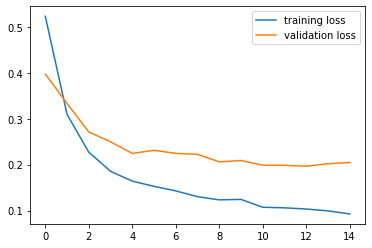

In [21]:
plt.plot(model_logs["training_loss_history"], label = "training loss")
plt.plot(model_logs["validation_loss_history"], label = "validation loss")
plt.legend()


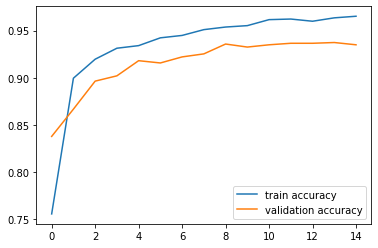

In [22]:
plt.plot(model_logs["train_accuracy"], label = "train accuracy")
plt.plot(model_logs["val_accuracy"], label = "validation accuracy")
plt.legend()

In [37]:
df_train_cm = pd.DataFrame(train_conf, columns = ["Normal", "Pneumonia"], index = ["Normal", "Pneumonia"])
df_val_cm = pd.DataFrame(val_conf, columns = ["Normal", "Pneumonia"], index = ["Normal", "Pneumonia"])

Text(0.5, 42.0, 'Predicted label')

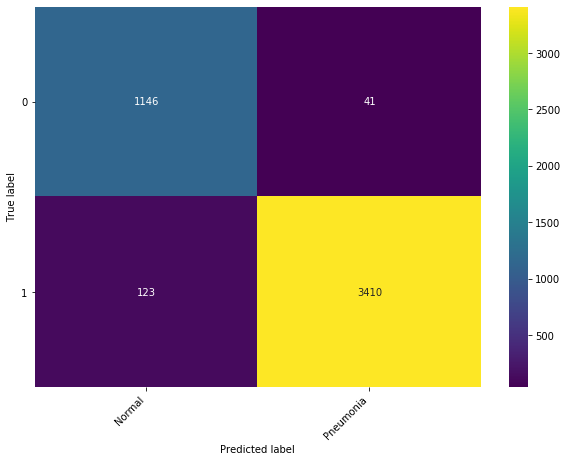

In [33]:
plt.figure(figsize = (10, 7))
heatmap = sns.heatmap(df_train_cm, annot = True, fmt = "d", cmap = "viridis")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = "right")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = "right")
plt.ylabel("True label")
plt.xlabel("Predicted label")

Text(0.5, 42.0, 'Predicted label')

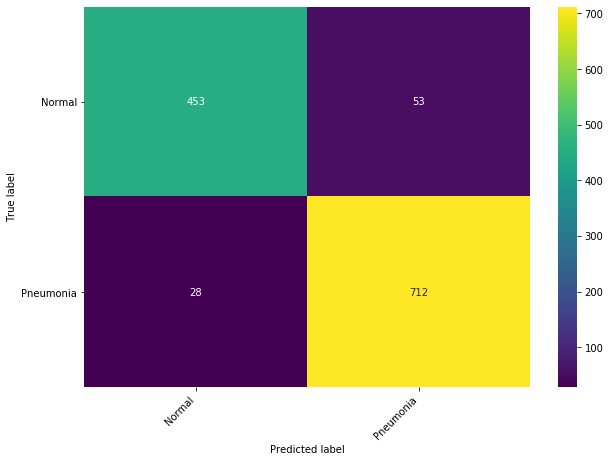

In [38]:
plt.figure(figsize = (10, 7))
heatmap = sns.heatmap(df_val_cm, annot = True, fmt = "d", cmap = "viridis")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = "right")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = "right")
plt.ylabel("True label")
plt.xlabel("Predicted label")